In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from random import choice
pd.options.mode.chained_assignment = None 
import pickle

In [3]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/Insert-Generic-Name-Here/'))
# sys.path

from lonelyboy.geospatial import plots as gsplt
from lonelyboy.geospatial import preprocessing as gspp
from lonelyboy.timeseries import lbtimeseries as tspp
# from lonelyboy.geospatial import group_patterns as gsgp


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import PyQt5
import matplotlib.pyplot as plt
from matplotlib import style;  style.use('ggplot')
get_ipython().magic('matplotlib qt')
# get_ipython().magic('matplotlib inline')

## Read AIS Data

In [3]:
vessel = pd.read_csv('./data/csv/nari_dynamic.csv')

In [4]:
cols = {'sourcemmsi': 'mmsi', 'navigationalstatus': 'status', 'rateofturn': 'turn', 'speedoverground': 'speed', 'courseoverground': 'course', 'trueheading': 'heading', 't': 'ts'}
vessel.rename(cols, axis='columns', inplace=True)
vessel.drop_duplicates(subset=['ts','mmsi'], inplace=True)
vessel.drop(['id', 'status'], axis=1, inplace=True, errors='ignore')

In [5]:
len(vessel)

18472981

In [6]:
len(vessel.mmsi.unique())

5055

In [6]:
vessel.head()

,mmsi,turn,speed,course,heading,lon,lat,ts
0,245257000,0.0,0.1,13.1,36,-4.465718,48.382490,1443650402
1,227705102,-127.0,0.0,262.7,511,-4.496571,48.382420,1443650403
2,228131600,-127.0,8.5,263.7,511,-4.644325,48.092247,1443650404
3,228051000,-127.0,0.0,295.0,511,-4.485108,48.381320,1443650405
4,227574020,-127.0,0.1,248.6,511,-4.495441,48.383660,1443650406


In [10]:
# tmp = vessel[:20000].copy()

* # #AIS_Records per Vessel (mmsi)

In [9]:
vessel = vessel.groupby('mmsi', group_keys=False).apply(len).to_frame().reset_index()
vessel.columns=['mmsi', 'no_of_records']
vessel.to_csv('stats/mmsis_no_of_records.csv', index=False)

In [24]:
tmp1 = pd.read_csv('data/csv/stats/mmsis_no_of_records.csv')
tmp1

,mmsi,no_of_records
0,923166,3
1,1234500,1
2,9105765,1
3,37100300,3502
4,205067000,75
5,205204000,13230
6,205209000,6
7,205227000,1
8,205277430,210
9,205309000,27790


* # #AIS_Records per Vessel (mmsi) per Day

In [59]:
vessel = vessel.groupby(['mmsi', pd.to_datetime(vessel.ts, unit='s').dt.date], group_keys=False).apply(len).to_frame().reset_index()
vessel.columns=['mmsi', 'date', '#records']
vessel.to_csv('stats/mmsis_no_of_records_per_day.csv', index=False)

In [14]:
pd.read_csv('data/csv/stats/no_of_records_per_day.csv')['#records'].mean()

100396.63586956522

* # #AIS_Records per Day

In [7]:
vessel = vessel.groupby([pd.to_datetime(vessel.ts, unit='s').dt.date], group_keys=False).apply(len).to_frame().reset_index()
vessel.columns=['date', '#records']
vessel.to_csv('stats/no_of_records_per_day.csv', index=False)

In [16]:
df = pd.read_csv('data/csv/stats/no_of_records_per_day.csv')

* # Average #AIS_Records per Day

In [7]:
tmp1 = vessel.groupby(['mmsi', pd.to_datetime(vessel.ts, unit='s').dt.date], group_keys=False).apply(len).to_frame().reset_index()
tmp1.columns=['mmsi', 'date', '#records']
tmp2 = tmp1.groupby('mmsi', group_keys=False).apply(lambda x: x['#records'].sum()/len(x)).to_frame().reset_index()
tmp2.columns=['mmsi','records_per_day']
tmp2.to_csv('stats/mean_records_per_day.csv', index=False)

In [15]:
tmp = pd.read_csv('data/csv/stats/mean_records_per_day.csv')

In [11]:
tmp['records_per_day'].max()

10952.727272727272

In [12]:
pd.cut(tmp['records_per_day'], [0, 2, 5, 10, 20, 40, 80, 160, 320, 460, 1280, 11000]).value_counts(sort=False).plot.bar(figsize=(12,10), cmap='tab20', title='Mean daily records per mmsi', rot=8)
plt.xlabel('Number of mean AIS records per day')
plt.ylabel('Number of MMSIs')
plt.savefig('Mean daily records per mmsi')

In [13]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [14]:
tmp['day_name'] = pd.Categorical(tmp['day_name'], categories=cats, ordered=True)
tmp = tmp.sort_values('day_name')

KeyError: 'day_name'

In [125]:
tmp.reset_index(inplace=True, drop=True)

In [128]:
tmp.drop(['index'], axis=1,inplace=True)

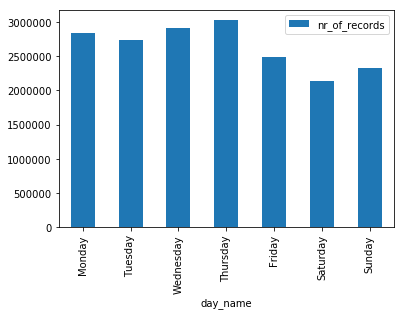

In [130]:
tmp.plot.bar(x='day_name')

In [47]:
tmp1.groupby('mmsi', group_keys=False).apply(lambda x: x['#records'].sum()/len(x)).to_frame().reset_index()

,mmsi,0
0,220625000,26.0
1,226338000,4.0
2,227008170,710.0
3,227123700,8.0
4,227307000,495.0
5,227318020,2.0
6,227415000,82.0
7,227443000,92.0
8,227483000,1.0
9,227574020,1074.0


In [28]:
tmp.groupby(['mmsi'], group_keys=True).apply(lambda x: pd.to_datetime(x.ts, unit='s').dt.date).to_frame().reset_index()

,mmsi,level_1,ts
0,220625000,2401,2015-09-30
1,220625000,2648,2015-09-30
2,220625000,2875,2015-09-30
3,220625000,2906,2015-09-30
4,220625000,2937,2015-09-30
5,220625000,2963,2015-09-30
6,220625000,3019,2015-09-30
7,220625000,3167,2015-09-30
8,220625000,4484,2015-09-30
9,220625000,4778,2015-09-30


In [75]:
vessel

NameError: name 'vessel' is not defined

In [26]:
pd.to_datetime(df.date).dt.month

AttributeError: 'Series' object has no attribute 'year'

In [131]:
# tst = df.groupby([pd.to_datetime(df.date).dt.weekday_name], group_keys=False).apply(lambda x : x['#records'].sum()).to_frame().reset_index()
# tst.columns = ['day_name', 'nr_of_records']
tmp.to_csv('stats/records_per_dayname.csv', index=False)

In [110]:
pd.to_datetime(df.date).dt.weekday_name

0      Wednesday
1       Thursday
2         Friday
3       Saturday
4         Sunday
5         Monday
6        Tuesday
7      Wednesday
8       Thursday
9         Friday
10      Saturday
11        Sunday
12        Monday
13       Tuesday
14     Wednesday
15      Thursday
16        Friday
17      Saturday
18        Sunday
19        Monday
20       Tuesday
21     Wednesday
22      Thursday
23        Friday
24      Saturday
25        Sunday
26        Monday
27       Tuesday
28     Wednesday
29      Thursday
         ...    
154    Wednesday
155     Thursday
156       Friday
157     Saturday
158       Sunday
159       Monday
160      Tuesday
161    Wednesday
162     Thursday
163       Friday
164     Saturday
165       Sunday
166       Monday
167      Tuesday
168    Wednesday
169     Thursday
170       Friday
171     Saturday
172       Sunday
173       Monday
174      Tuesday
175    Wednesday
176     Thursday
177       Friday
178     Saturday
179       Sunday
180       Monday
181      Tuesd

In [57]:
tst.columns = ['year']

In [103]:
tst

,index,0
0,2015-09-28/2015-10-04,6906
1,2015-10-05/2015-10-11,98128
2,2015-10-12/2015-10-18,104364
3,2015-10-19/2015-10-25,97731
4,2015-10-26/2015-11-01,82973
5,2015-11-02/2015-11-08,101608
6,2015-11-09/2015-11-15,126083
7,2015-11-16/2015-11-22,161489
8,2015-11-23/2015-11-29,154338
9,2015-11-30/2015-12-06,105845


## Vessel-Static Data Statistics

In [92]:
vessel_static = pd.read_csv('./data/csv/nari_static.csv')
vessel_cat_list = pd.read_csv('./data/csv/Ship Types List.csv')
vessel_det_cat_list = pd.read_csv('./data/csv/Ship Types Detailed List.csv')

tmp = vessel_static.shiptype.value_counts().to_frame().reset_index()
tmp.columns = ['shiptype', '#records']

/home/andretri7/anaconda3/envs/gis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [98]:
vessel_static

,sourcemmsi,imonumber,callsign,shipname,shiptype,tobow,tostern,tostarboard,toport,eta,draught,destination,mothershipmmsi,t
0,304091000,9509255.0,V2GU5,HC JETTE-MARIT,70.0,130.0,30.0,18.0,6.0,04-09 20:00,10.1,BREST,NaN,1443650423
1,228037600,0.0,FIHX,AEROUANT BREIZH,30.0,6.0,9.0,5.0,2.0,00-00 24:60,0.0,,NaN,1443650457
2,228064900,8304816.0,FITO,VN SAPEUR,51.0,21.0,54.0,10.0,6.0,29-09 12:00,5.9,RADE DE BREST,NaN,1443650471
3,227705102,262144.0,FGD5860,BINDY,60.0,9.0,26.0,5.0,4.0,00-00 24:60,0.0,,NaN,1443650474
4,227415000,0.0,FHAF,F/V JEREMI SIMON,90.0,11.0,9.0,3.0,3.0,00-00 24:60,0.0,,NaN,1443650479
5,226263000,9308687.0,FZTC,ABEILLE BOURBON,51.0,36.0,44.0,8.0,8.0,31-12 00:00,6.0,SALVAGE TUG,NaN,1443650516
6,245257000,9148142.0,PFHD,EEMS CARRIER,70.0,75.0,9.0,3.0,8.0,30-09 17:00,2.7,BREST,NaN,1443650535
7,227002330,0.0,FO4922,ANDRE COLIN,60.0,15.0,20.0,2.0,5.0,25-09 10:30,1.8,BREST,NaN,1443650591
8,227003050,0.0,FV5533,ENEZ EUSSA 3,60.0,25.0,20.0,4.0,5.0,29-09 19:50,2.8,BREST,NaN,1443650611
9,227443000,0.0,FITP,F/V PROMETHEE,30.0,11.0,9.0,3.0,3.0,00-00 24:60,0.0,,NaN,1443650629


In [5]:
vessel_cat_list

,id_shiptype,shiptype_min,shiptype_max,type_name,ais_type_summary
0,1,10,19,Reserved,Unspecified
1,2,20,28,Wing In Grnd,Wing in Grnd
2,3,29,29,SAR Aircraft,Search and Rescue
3,4,30,30,Fishing,Fishing
4,5,31,31,Tug,Tug
5,6,32,32,Tug,Tug
6,7,33,33,Dredger,Special Craft
7,8,34,34,Dive Vessel,Special Craft
8,9,35,35,Military Ops,Special Craft
9,10,36,36,Sailing Vessel,Sailing Vessel


In [6]:
vessel_det_cat_list.head()

,id_detailedtype,detailed_type,id_shiptype
0,1,Wing In Ground Effect Vessel,2
1,2,Trawler,4
2,3,Fishery Protection/Research,4
3,4,Fish Carrier,4
4,5,Fish Factory,4


In [37]:
# vessel_cat_list.join(vessel_det_cat_list, how='outer', on='id_shiptype', lsuffix='_caller', rsuffix='_other').dropna(how='all', subset=['id_shiptype_caller', 'shiptype_min', 'shiptype_max', 'type_name', 'ais_type_summary'])
# vessel_cat_list.join(vessel_det_cat_list, how='inner', on='id_shiptype')
# vessel_cat_list.merge(vessel_det_cat_list, on='id_shiptype', how='inner')
ves_static = vessel_static.merge(vessel_det_cat_list, left_on='shiptype', right_on='id_detailedtype', how='left')
ves_static.head()

,sourcemmsi,imonumber,callsign,shipname,shiptype,tobow,tostern,tostarboard,toport,eta,draught,destination,mothershipmmsi,t,id_detailedtype,detailed_type,id_shiptype
0,304091000,9509255.0,V2GU5,HC JETTE-MARIT,70.0,130.0,30.0,18.0,6.0,04-09 20:00,10.1,BREST,NaN,1443650423,70.0,Hovercraft,14.0
1,228037600,0.0,FIHX,AEROUANT BREIZH,30.0,6.0,9.0,5.0,2.0,00-00 24:60,0.0,,NaN,1443650457,30.0,Cutter Suction Dredger,7.0
2,228064900,8304816.0,FITO,VN SAPEUR,51.0,21.0,54.0,10.0,6.0,29-09 12:00,5.9,RADE DE BREST,NaN,1443650471,51.0,Naval Auxiliary Tug,9.0
3,227705102,262144.0,FGD5860,BINDY,60.0,9.0,26.0,5.0,4.0,00-00 24:60,0.0,,NaN,1443650474,60.0,Naval Patrol Vessel,9.0
4,227415000,0.0,FHAF,F/V JEREMI SIMON,90.0,11.0,9.0,3.0,3.0,00-00 24:60,0.0,,NaN,1443650479,90.0,Waste Disposal Vessel,24.0


In [38]:
ves_static.loc[ves_static.id_shiptype==4].detailed_type

Series([], Name: detailed_type, dtype: object)

In [207]:
tmp.head()

,shiptype,#records
0,60.0,179035
1,70.0,155302
2,30.0,133194
3,51.0,86798
4,36.0,72983


In [208]:
tmp['type_name'] = np.nan
tmp['ais_type_summary'] = np.nan

for row in tmp.itertuples(index=True):
    ves_type = vessel_cat_list.loc[(row.shiptype >= vessel_cat_list.shiptype_min) & (row.shiptype <= vessel_cat_list.shiptype_max)][['type_name', 'ais_type_summary']]
    if (len(ves_type) > 0):
        tmp.loc[row.Index, 'type_name'] = ves_type.type_name.values[0]
        tmp.loc[row.Index, 'ais_type_summary'] = ves_type.ais_type_summary.values[0]

tmp.fillna('Unknown', inplace=True)

In [241]:
tmp.groupby('type_name')['#records'].sum().sort_values().to_frame().reset_index().plot.barh(x='type_name', y='#records', cmap='tab20', rot=25, legend=False)
# plt.ylabel('Vessel Type')
plt.ylabel('')
plt.xlabel('#Vessels')

Text(0.5, 0, '#Vessels')

* ### Vessel-Dynamic Statistics I

In [4]:
mean_records_per_day = pd.read_csv('./data/csv/stats/mean_records_per_day.csv')
mmsis_no_of_records = pd.read_csv('./data/csv/stats/mmsis_no_of_records.csv')
no_of_records_per_day = pd.read_csv('./data/csv/stats/no_of_records_per_day.csv')
records_per_dayname = pd.read_csv('./data/csv/stats/records_per_dayname.csv')
records_per_week = pd.read_csv('./data/csv/stats/records_per_week.csv')

In [5]:
mean_records_per_day

,mmsi,records_per_day
0,923166,3.000000
1,1234500,1.000000
2,9105765,1.000000
3,37100300,1167.333333
4,205067000,18.750000
5,205204000,1323.000000
6,205209000,6.000000
7,205227000,1.000000
8,205277430,105.000000
9,205309000,646.279070


In [26]:
out = pd.cut(mmsis_no_of_records['no_of_records'], [0, 2, 4, 8, 17, 35, 71, 142, 285, 570, 1141, 2282, 4565, 9130, 18260, 36520, 1168640]) 

ax = out.value_counts(sort=False).plot.bar(figsize=(12,10), fontsize=14, cmap='tab20', title='Number of AIS signals per vessel at the entire period of study', rot=15)
ax.set_xticklabels([str(c).split(' ')[1].split(']')[0] for c in out.cat.categories])
plt.xlabel('Number of AIS signals', fontsize=14)
plt.ylabel('Number of MMSIs', fontsize=14)
# plt.savefig('Number of AIS signals at the entire period of study')

Text(0, 0.5, 'Number of MMSIs')

In [ ]:
out = pd.cut(mean_records_per_day['records_per_day'], [0, 2, 5, 10, 20, 40, 80, 160, 320, 640, 1280, 11000])

ax = out.value_counts(sort=False).plot.bar(figsize=(12,10), fontsize=14, cmap='tab20', title='Number of AIS signals per vessel at a daily basis', rot=0)
ax.set_xticklabels([str(c).split(' ')[1].split(']')[0] for c in out.cat.categories])
plt.xlabel('Number of AIS records per day', fontsize=14)
plt.ylabel('Number of MMSIs', fontsize=14)
# plt.savefig('Mean daily records per mmsi')

In [28]:
records_per_week.plot.bar(cmap='tab20', fontsize=14, title='Number of Records per Week', rot=0, legend=False)
plt.xlabel('Week Number (Start:01-10-2015, Finish:31-03-2016)', fontsize=14)
plt.ylabel('#Records', fontsize=14)

Text(0, 0.5, '#Records')

In [27]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
no_of_records_per_day['day_name'] = pd.to_datetime(no_of_records_per_day.date).dt.weekday_name 
no_of_records_per_day['day_name'] = pd.Categorical(no_of_records_per_day['day_name'], categories=cats, ordered=True) 
no_of_records_per_day = no_of_records_per_day.sort_values('day_name')

no_of_records_per_day.reset_index(inplace=True, drop=True)
no_of_records_per_day.groupby('day_name').apply(sum).plot.bar(cmap='tab20', fontsize=14, legend=False, title='Number of Records per Weekday', rot=0)
plt.xlabel('')
plt.ylabel('#Records', fontsize=14)

Text(0, 0.5, '#Records')

* ### Vessel-Dynamic Statistics II (Velocity, Acceleration, Bearing)

In [ ]:
%%time
ves_feat = []
for i in range(6):
    df = pd.read_csv(f'data/csv/nari_dynamic_vanilla_features/nari_dynamic_vanilla_features_{i}.csv')
    ves_feat.append(df[['mmsi', 'velocity', 'acceleration', 'bearing']])
    
ves_feat = pd.concat(ves_feat, ignore_index=True)

In [ ]:
out = pd.cut(ves_feat.velocity, [0, 10, 20, 30, 40, 50, 60, np.round(ves_feat.velocity.max())+1])
ax = out.value_counts(sort=False).plot.area(figsize=(12,10), fontsize=14, cmap='tab20', title='Vessel Velocity Distribution', rot=0)
ax.set_xticklabels([str(c).split(' ')[1].split(']')[0] for c in out.cat.categories])
plt.xlabel('Velocity (knots; nautical miles per hour)', fontsize=14)
plt.ylabel('#Occurrences', fontsize=14)

In [ ]:
window=150
no_of_bins=[-94082, -3000, -1000, -10, -2, -0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5, 2, 10, 1000, 3000, 94082] 

out = pd.cut(ves_feat.acceleration, no_of_bins)
ax = out.value_counts(sort=False).plot.area(figsize=(12,10), fontsize=14, cmap='tab20', title='Vessel Acceleration Distribution', rot=10)
ax.set_xticklabels([-3000, -10, -0.5, -0.1, 0, 0.5, 10, 3000])
plt.xlabel('Acceleration', fontsize=14)
plt.ylabel('#Occurrences', fontsize=14)

In [ ]:
# pd.cut(ves_feat.bearing, [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]).value_counts(sort=False).plot.area(figsize=(12,10), fontsize=14, cmap='tab20', title='Vessel Course Distribution', rot=15)
out = pd.cut(ves_feat.bearing, [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
ax = out.value_counts(sort=False).plot.bar(figsize=(12,10), fontsize=14, cmap='tab20', title='Vessel Course Distribution', rot=0)
ax.set_xticklabels([str(c).split(' ')[1].split(']')[0] for c in out.cat.categories])
plt.xlabel('Course', fontsize=14)
plt.ylabel('#Occurrences', fontsize=14)